## 1. 環境設定與資料載入
---
在使用 Zipline 進行回測前，需要設定 TEJ API 相關環境變數，並載入股價資料。

1. 設定環境變數 ： 在 Jupyter Notebook 中執行以下程式碼，將 `YOUR_API_KEY` 替換為您的 TEJ API Key。`mdate` 設定資料區間，`ticker` 設定股票代碼。

In [ ]:
import os
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
os.environ['TEJAPI_KEY'] = "YOUR_API_KEY" # 請替換為您的 API Key
os.environ['mdate'] = "20170601 20230702" # 資料起始日與結束日
os.environ['ticker'] = '2330 IR0001' # 股票代碼 (2330 為台積電)

2. 載入股價資料 ： 使用 `!zipline ingest` 指令將設定好的資料載入到 Zipline 的 bundle 中。

In [4]:
! zipline ingest -b tquant

[2026-01-13 08:08:55.138568] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]   
Currently used TEJ API key call quota 62/100000 (0.06%)
Currently used TEJ API key data quota 652817/10000000 (6.53%)
[2026-01-13 08:08:57.098017] INFO: zipline.data.bundles.core: Ingest tquant successfully.


## 2. 策略核心：Zipline 回測函數
---
Zipline 策略主要由四個核心函式構成：`initialize`、`handle_data`、`analyze` 和 `run_algorithm`。


### 2.1. initialize(context)
* 功能 ：在回測開始前執行一次，用於設定初始環境，例如設定滑價、手續費，或初始化策略所需的變數。
* 範例 ：設定滑價、手續費，並初始化 `context.day` 和 `context.has_ordered` 變數。

In [5]:
from zipline.api import set_slippage, set_commission
from zipline.finance import slippage, commission

def initialize(context):
    context.day = 0
    context.has_ordered = False # 追蹤是否已下單
    set_slippage(slippage.FixedSlippage()) # 設定固定滑價
    set_commission(commission.PerShare(cost=0.00285)) # 設定每股手續費

### 2.2. handle_data(context, data)
* 功能 ：在每個交易日結束時執行一次，用於定義交易邏輯、下單操作及記錄交易資訊。
* 參數 ：
    * `context`: 包含策略狀態的物件，可在不同函式間共享資訊。
    * `data`: 包含當前交易日所有資產的歷史與當前市場資料。
* 範例 ：在第一個交易日買入台積電 (2330) 股票，並記錄相關資訊。

In [9]:
from zipline.api import order, record, symbol

def handle_data(context, data):
    context.day += 1 #記錄這是回測第幾天
    if not context.has_ordered: #確保不會重複下單
        order(symbol("2330"), 1000) #買入1000股台積電
        context.has_ordered = True #指示系統已經下單

    # 紀錄交易日、是否已經下單以及台積電收盤價
    record(
        trade_days = context.day,
        has_ordered = context.has_ordered,
        TSMC = data.current(symbol("2330"), "close")
    )


### 2.3. analyze(context, perf)
* 功能 ：在回測結束後執行一次，用於分析策略績效並進行視覺化。
* 參數 ：
    * `context`: 同 `initialize` 和 `handle_data` 中的 `context`。
    * `perf`: 包含回測結果的 DataFrame，可提取績效指標。
* 範例 ：繪製投資組合價值與台積電股價走勢圖。

In [22]:
import matplotlib.pyplot as plt

def analyze(context, perf):
    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, figsize=(18,8))# 分割兩層樓畫布
    perf.portfolio_value.plot(ax=ax1, title='portfolio_value (Capital)')
    perf['TSMC'].plot(ax=ax2, title= 'TSMC Stock Price (Close)')
    plt.tight_layout()
    plt.show


### 2.4. run_algorithm
* 功能 ： 啟動 Zipline 回測引擎，整合上述函式並執行策略。
* 參數 ：
    * `start`, `end`: 回測的起始與結束日期。
    * `initialize`, `handle_data`, `analyze`: 傳入上述定義的函式。
    * `capital_base`: 初始投資金額。
    * `bundle`: 使用的資料 bundle 名稱。
* 範例 ：執行從 2018 年底到 2023 年中的回測。

findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans TC, Heiti TC, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans TC, Heiti TC, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans TC, Heiti TC, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans TC, Heiti TC, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans TC, Heiti TC, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans TC, Heiti TC, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans TC, Heiti TC, Arial Unicode MS
findfont: Generic fa

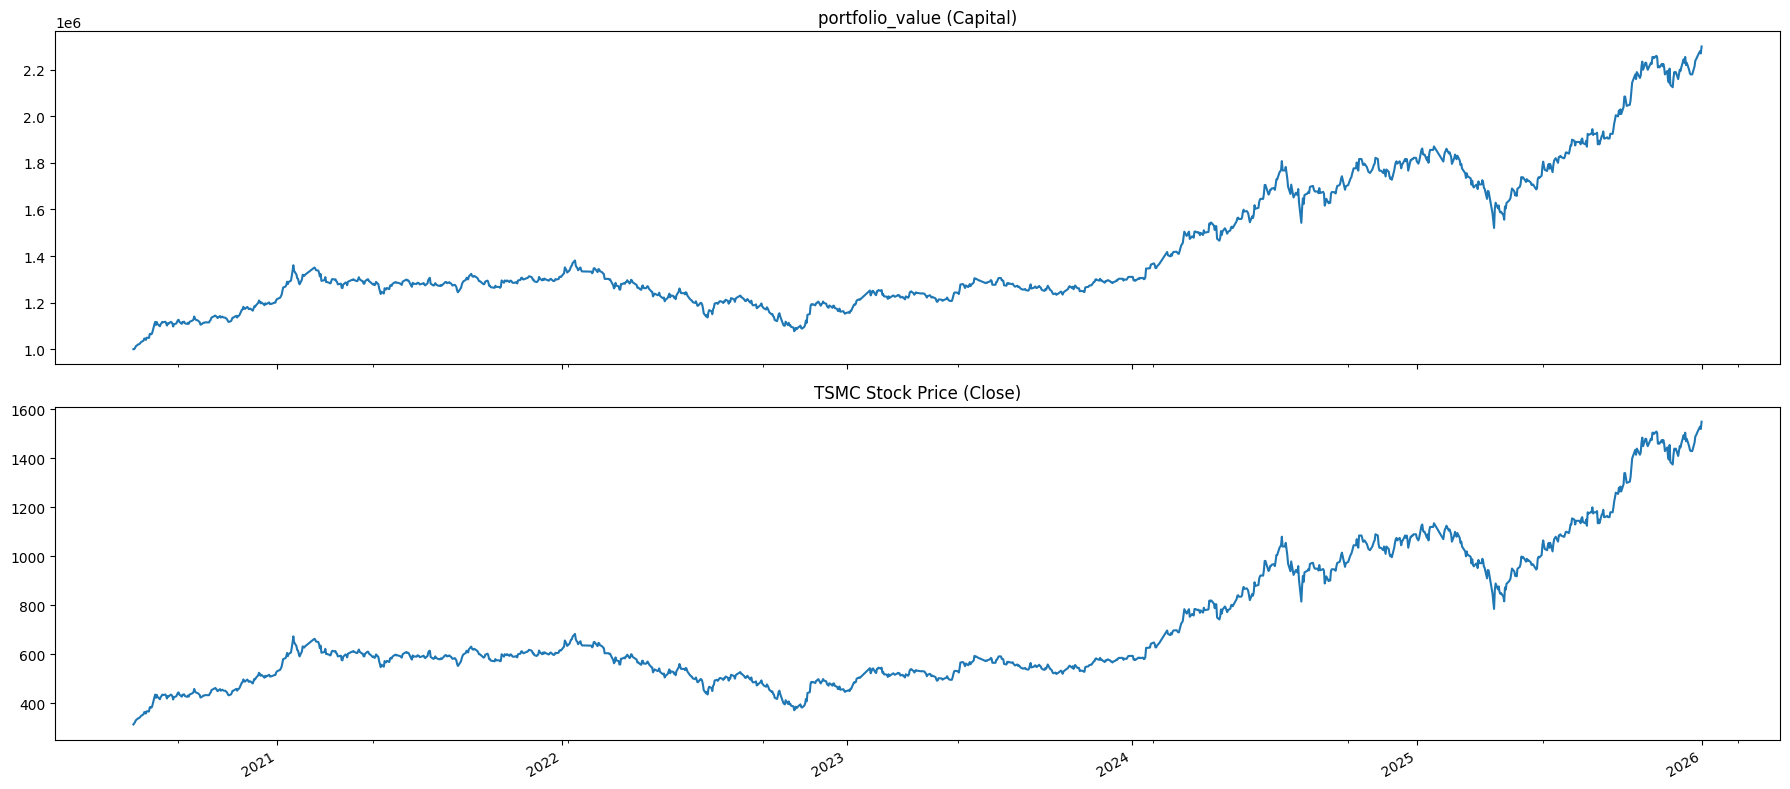

In [23]:
from zipline.utils.calendar_utils import get_calendar # 確保用這行抓
from zipline import run_algorithm
import pandas as pd

start_date = pd.Timestamp('2020-6-30', tz='utc')
end_date = pd.Timestamp('2025-12-31', tz='utc')

results = run_algorithm(
    start = start_date,
    end = end_date,
    initialize = initialize,
    capital_base = 1e6,
    handle_data = handle_data,
    analyze = analyze,
    data_frequency = 'daily',
    bundle = 'tquant',
    trading_calendar = get_calendar('TEJ')
)

## 3. 執行回測與結果分析
---
將上述所有程式碼片段依序在 Jupyter Notebook 中執行，run_algorithm 函式將會啟動回測，並在結束後自動呼叫 analyze 函式顯示績效圖表。

1. `results` 變數會儲存回測期間的詳細績效數據，您可以進一步檢視：

In [17]:
results

,period_open,period_close,short_value,starting_exposure,long_exposure,orders,short_exposure,returns,gross_leverage,starting_value,...,treasury_period_return,algo_volatility,max_leverage,trading_days,period_label,benchmark_period_return,excess_return,benchmark_volatility,sharpe,max_drawdown
2020-06-30 13:30:00+08:00,2020-06-30 09:01:00+08:00,2020-06-30 13:30:00+08:00,0.0,0.0,0.0,"[{'id': '3c4cbb44fc3e4d5d9c2f1656b4d27670', 'd...",0.0,0.000000,0.000000,0.0,...,0.0,NaN,0.000000,1,2020-06,0.0,0.000000,NaN,NaN,0.000000
2020-07-01 13:30:00+08:00,2020-07-01 09:01:00+08:00,2020-07-01 13:30:00+08:00,0.0,0.0,317500.0,"[{'id': '3c4cbb44fc3e4d5d9c2f1656b4d27670', 'd...",0.0,-0.000003,0.317501,0.0,...,0.0,0.000032,0.317501,2,2020-07,0.0,-0.000003,0.0,-11.224972,-0.000003
2020-07-02 13:30:00+08:00,2020-07-02 09:01:00+08:00,2020-07-02 13:30:00+08:00,0.0,317500.0,322000.0,[],0.0,0.004500,0.320558,317500.0,...,0.0,0.041256,0.320558,3,2020-07,0.0,0.004497,0.0,9.156446,-0.000003
2020-07-03 13:30:00+08:00,2020-07-03 09:01:00+08:00,2020-07-03 13:30:00+08:00,0.0,322000.0,329500.0,[],0.0,0.007466,0.325594,322000.0,...,0.0,0.058122,0.325594,4,2020-07,0.0,0.011997,0.0,12.967737,-0.000003
2020-07-06 13:30:00+08:00,2020-07-06 09:01:00+08:00,2020-07-06 13:30:00+08:00,0.0,329500.0,338000.0,[],0.0,0.008399,0.331211,329500.0,...,0.0,0.063307,0.331211,5,2020-07,0.0,0.020497,0.0,16.211214,-0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-24 13:30:00+08:00,2025-12-24 09:01:00+08:00,2025-12-24 13:30:00+08:00,0.0,1490000.0,1495000.0,[],0.0,0.002233,0.666074,1490000.0,...,0.0,0.145719,0.668291,1340,2025-12,0.0,1.244496,0.0,1.116469,-0.219950
2025-12-26 13:30:00+08:00,2025-12-26 09:01:00+08:00,2025-12-26 13:30:00+08:00,0.0,1495000.0,1510000.0,[],0.0,0.006683,0.668291,1495000.0,...,0.0,0.145688,0.668291,1341,2025-12,0.0,1.259496,0.0,1.124493,-0.219950
2025-12-29 13:30:00+08:00,2025-12-29 09:01:00+08:00,2025-12-29 13:30:00+08:00,0.0,1510000.0,1530000.0,[],0.0,0.008852,0.671201,1510000.0,...,0.0,0.145677,0.671201,1342,2025-12,0.0,1.279496,0.0,1.135149,-0.219950
2025-12-30 13:30:00+08:00,2025-12-30 09:01:00+08:00,2025-12-30 13:30:00+08:00,0.0,1530000.0,1520000.0,[],0.0,-0.004387,0.669752,1530000.0,...,0.0,0.145639,0.671201,1343,2025-12,0.0,1.269496,0.0,1.128947,-0.219950


2. 透過這個簡單的範例，您已成功執行了第一個 TQuant Lab Zipline 回測策略！您可以嘗試修改 `handle_data` 中的邏輯，探索更多元的交易策略。